# Object segmentation with Region Growing with Shape Prior

In [1]:
%matplotlib inline
import os, sys, glob
import pickle
import numpy as np
import pandas as pd
from PIL import Image
# from scipy import spatial, ndimage
from skimage import segmentation as sk_segm
import matplotlib.pylab as plt

In [2]:
sys.path += [os.path.abspath('.'), os.path.abspath('..')] # Add path to root
import segmentation.utils.data_io as tl_io
import segmentation.utils.drawing as tl_visu
import segmentation.superpixels as tl_spx
import segmentation.region_growing as tl_rg

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Loading data

In [5]:
COLORS = 'bgrmyck'
PATH_IMAGES = tl_io.update_path(os.path.join('images', 'drosophila_ovary_slice'), absolute=True)
PATH_DATA = tl_io.update_path('data', absolute=True)
PATH_OUT = tl_io.update_path('output', absolute=True)
print ([os.path.basename(p) for p in glob.glob(os.path.join(PATH_IMAGES, '*')) if os.path.isdir(p)])

['annot_eggs', 'annot_struct', 'center_levels', 'images', 'segm', 'segm_rgb']


In [6]:
dir_img = os.path.join(PATH_IMAGES, 'image')
dir_segm = os.path.join(PATH_IMAGES, 'segm')
dir_annot = os.path.join(PATH_IMAGES, 'annot_eggs')
dir_center = os.path.join(PATH_IMAGES, 'annot_eggs')

## Estimate shape models

In [7]:
def compute_prior_map(cdist, size=(500, 800), step=5):
    prior_map = np.zeros(size)
    centre = np.array(size) / 2
    for i in np.arange(prior_map.shape[0], step=step):
        for j in np.arange(prior_map.shape[1], step=step):
            prior_map[i:i+step, j:j+step] = tl_rg.compute_shape_prior_table_cdf([i, j], cdist, centre, angle_shift=0)
    return prior_map

((0, 350), None)

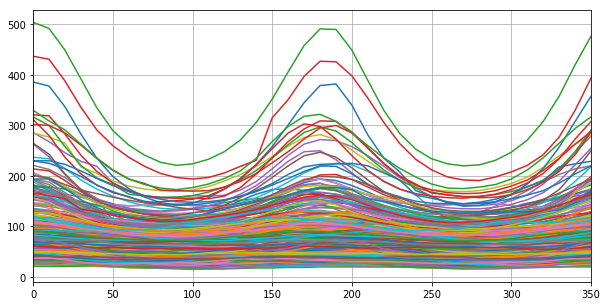

In [9]:
df = pd.DataFrame().from_csv(os.path.join(PATH_DATA, 'egg_ray_shapes.csv'))
list_rays = df.values.tolist()
fig = plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, 360, len(list_rays[0]) + 1)[:-1], np.array(list_rays).T, '-')
plt.xlim([0, 350]), plt.grid()

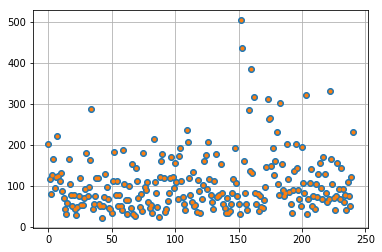

In [10]:
maxima = np.max(list_rays, axis=1)
plt.plot(maxima, 'o'), plt.grid()
# list_rays += [ray * (1 + np.random.random() / 10.) for ray in np.array(list_rays)[maxima > 250]]
# list_rays += [ray * (1 + np.random.random() / 10.) for ray in np.array(list_rays)[maxima > 250]]
plt.plot(np.max(list_rays, axis=1), '.')

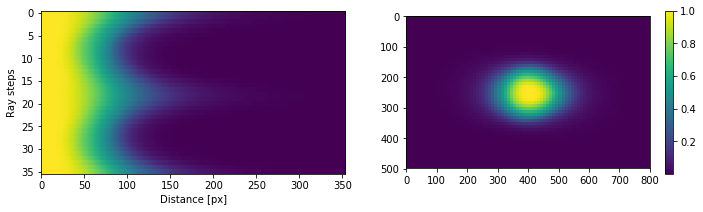

In [11]:
# list_cdf = tl_rg.transform_rays_model_cdf_histograms(list_rays, nb_bins=15)
mm, list_cdf = tl_rg.transform_rays_model_cdf_mixture(list_rays, 15)
cdf = np.array(np.array(list_cdf))

with open(os.path.join(PATH_DATA, 'RG2SP_single-model_mixture.pkl'), 'w') as fp:
    pickle.dump({'name': 'cdf', 'cdfs': cdf, 'mix_model': mm}, fp)

fig = plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1), plt.imshow(cdf, aspect='auto'), plt.ylabel('Ray steps'), plt.xlabel('Distance [px]')
_= plt.subplot(1, 2, 2), plt.imshow(compute_prior_map(cdf, step=10)), plt.colorbar()
# fig.savefig(os.path.join(PATH_OUT, 'shape-prior.pdf'), bbox_inches='tight')

### Computing shape prior model

In [12]:
model, list_mean_cdf = tl_rg.transform_rays_model_sets_mean_cdf_mixture(list_rays, 15)
# model, list_mean_cdf = tl_rg.transform_rays_model_sets_mean_cdf_kmeans(list_rays, 25)

with open(os.path.join(PATH_DATA, 'RG2SP_multi-model_mixture.pkl'), 'w') as fp:
    pickle.dump({'name': 'set_cdfs', 'cdfs': list_mean_cdf, 'mix_model': model}, fp)

In [13]:
file_model = pickle.load(open(os.path.join(PATH_DATA, 'RG2SP_multi-model_mixture.pkl'), 'r'))
print (file_model.keys())
list_mean_cdf = file_model['cdfs']
model = file_model['mix_model']

['mix_model', 'cdfs', 'name']


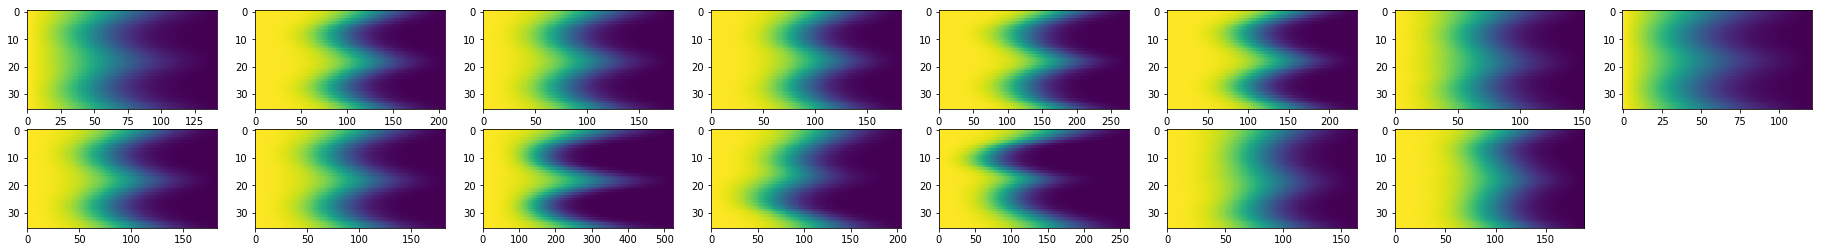

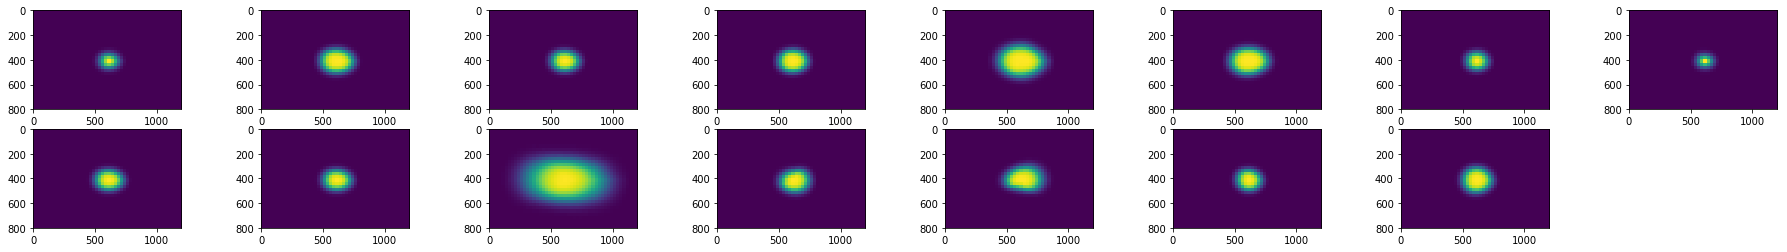

In [14]:
subfig_per_row = 8
subfig_per_col = int(np.ceil(len(list_mean_cdf) / float(subfig_per_row)))
fig = plt.figure(figsize=(4 * subfig_per_row, 2 * subfig_per_col))
for i in range(len(list_mean_cdf)):
    plt.subplot(subfig_per_col, subfig_per_row, i+1), plt.imshow(list_mean_cdf[i][1], aspect='auto')
fig = plt.figure(figsize=(4 * subfig_per_row, 2 * subfig_per_col))
for i in range(len(list_mean_cdf)):
    plt.subplot(subfig_per_col, subfig_per_row, i+1)
    plt.imshow(compute_prior_map(list_mean_cdf[i][1], size=(800, 1200), step=25))

## Loading Image

In [15]:
name = 'insitu7545'
# name = 'insitu4200'
img = np.array(Image.open(os.path.join(dir_img, name + '.jpg')))
seg = np.array(Image.open(os.path.join(dir_segm, name + '.png')))
# seg = np.array(Image.open(os.path.join(dir_segm, name + '_gc.png')))
centers = pd.DataFrame.from_csv(os.path.join(dir_center, name + '.csv')).values
centers[:, [0, 1]] = centers[:, [1, 0]]
FIG_SIZE = (12. * np.array(img.shape[:2]) / np.max(img.shape))[::-1]
# print centers

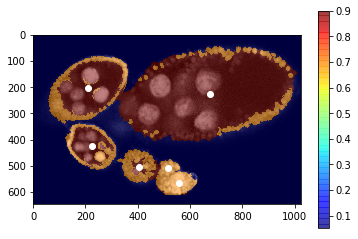

In [16]:
labels_fg_prob = [0.05, 0.7, 0.9, 0.9]
# labels_fg_prob = [0.05, 0.8, 0.95, 0.95]

# plt.figure(figsize=FIG_SIZE)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.imshow(np.array(labels_fg_prob)[seg], alpha=0.5, cmap=plt.cm.jet), plt.colorbar()
plt.plot(centers[:, 1], centers[:, 0], 'ow')
_= plt.xlim([0, img.shape[1]]),  plt.ylim([img.shape[0], 0])

### Compute superpixels

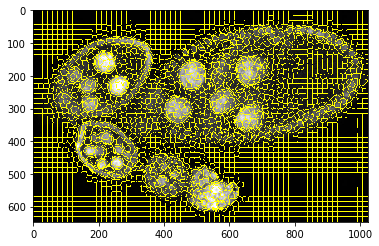

In [17]:
slic = tl_spx.segment_slic_img2d(img, sp_size=15, rltv_compact=0.35)
# plt.figure(figsize=FIG_SIZE[::-1])
_= plt.imshow(sk_segm.mark_boundaries(img[:, :, 0], slic))

Visualisation functions

In [18]:
from IPython.html import widgets
from IPython.display import display

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Region growing - Greedy

### Single model

['shifts', 'lut_data_cost', 'lut_shape_cost', 'centres', 'energy', 'labels']


(<matplotlib.image.AxesImage at 0x7f260901ec90>,
 <matplotlib.contour.QuadContourSet at 0x7f260901efd0>)

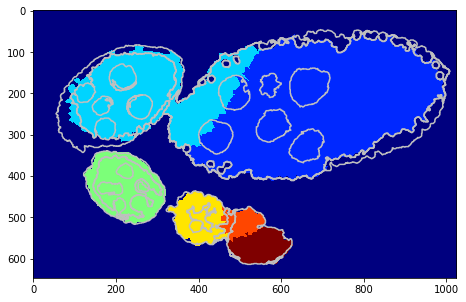

In [19]:
debug_gd_1m = {}
labels_greedy = tl_rg.region_growing_shape_slic_greedy(seg, slic, centers, (None, cdf), 'cdf', labels_fg_prob, 
                    coef_shape=1., coef_pairwise=5., prob_label_trans=[0.1, 0.01], greedy_tol=2e-1,
                    allow_obj_swap=True, dict_thresholds=tl_rg.DEFAULT_RG2SP_THRESHOLDS, nb_iter=250, dict_debug_history=debug_gd_1m)
segm_obj = labels_greedy[slic]
print (debug_gd_1m.keys())
fig = plt.figure(figsize=FIG_SIZE)
plt.imshow(segm_obj, cmap=plt.cm.jet), plt.contour(seg, levels=np.unique(seg), colors='#bfbfbf')

Interastive visualisation - over iterations

<function __main__.show_partial>

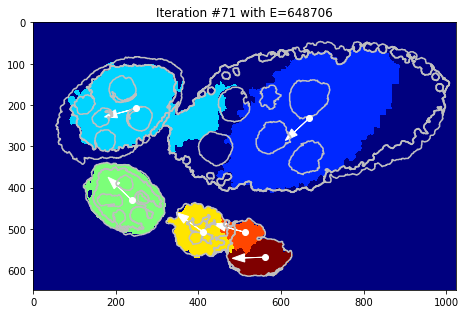

In [20]:
def show_partial(i):
    plt.close(), tl_visu.draw_rg2sp_results(plt.figure(figsize=FIG_SIZE).gca(), seg, slic, debug_gd_1m, i)
# show the interact
widgets.interact(show_partial, i=(0, len(debug_gd_1m['energy']) -1))

### Mixture model

['shifts', 'lut_data_cost', 'lut_shape_cost', 'centres', 'energy', 'labels']


(<matplotlib.image.AxesImage at 0x7f2609046750>,
 <matplotlib.contour.QuadContourSet at 0x7f26090469d0>)

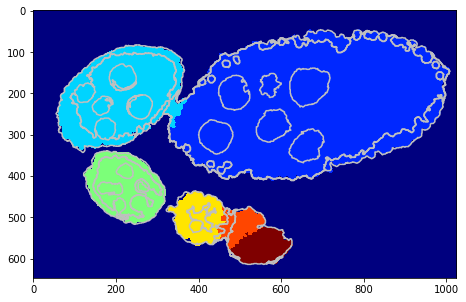

In [21]:
debug_gd_mm = {}
labels_greedy = tl_rg.region_growing_shape_slic_greedy(seg, slic, centers, (model, list_mean_cdf), 'set_cdfs', labels_fg_prob, 
                    coef_shape=5., coef_pairwise=15., prob_label_trans=[0.1, 0.03], greedy_tol=3e-1,
                    allow_obj_swap=True, dict_thresholds=tl_rg.DEFAULT_RG2SP_THRESHOLDS, nb_iter=250, dict_debug_history=debug_gd_mm)
segm_obj = labels_greedy[slic]
print (debug_gd_mm.keys())
fig = plt.figure(figsize=FIG_SIZE)
plt.imshow(segm_obj, cmap=plt.cm.jet), plt.contour(seg, levels=np.unique(seg), colors='#bfbfbf')

Interastive visualisation - over iterations

<function __main__.show_partial>

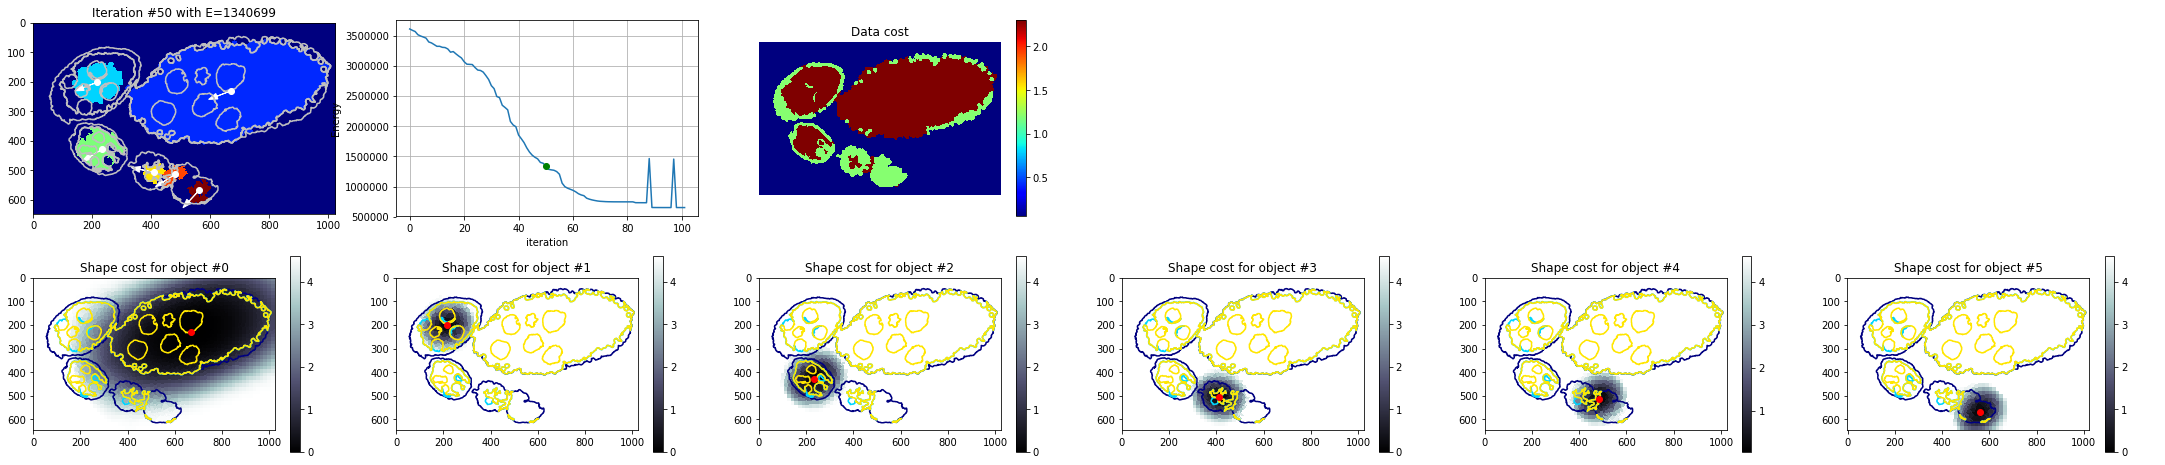

In [22]:
def show_partial(i):
    plt.close(), tl_visu.figure_rg2sp_debug_complete(seg, slic, debug_gd_mm, i, max_size=5)
# show the interact
widgets.interact(show_partial, i=(0, len(debug_gd_mm['energy']) - 1))

### Compare energy

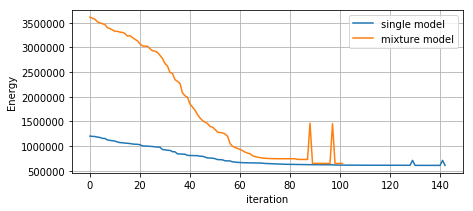

In [23]:
fig = plt.figure(figsize=(7, 3))
plt.plot(debug_gd_1m['energy'], label='single model')
plt.plot(debug_gd_mm['energy'], label='mixture model')
_= plt.ylabel('Energy'), plt.xlabel('iteration'), plt.grid(), plt.legend(loc='upper right')

### Visualise some iterations

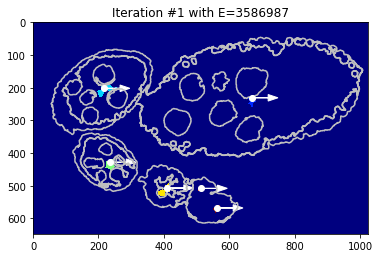

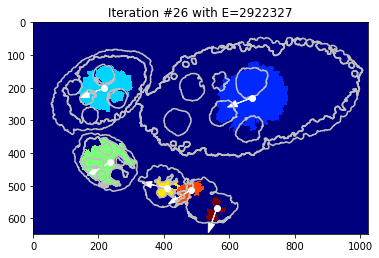

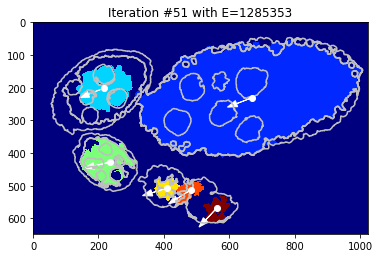

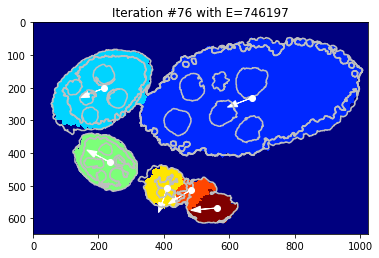

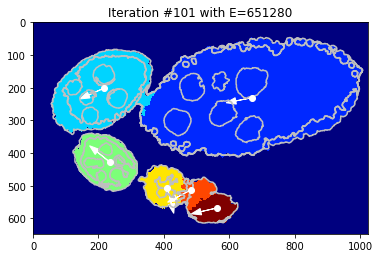

In [24]:
nb_iter = len(debug_gd_mm['energy'])
for i in np.linspace(1, nb_iter - 1, 5):
    _= tl_visu.draw_rg2sp_results(plt.figure().gca(), seg, slic, debug_gd_mm, int(i))

### Exporting iterations

In [35]:
nb_iter = len(debug_gd_mm['energy'])
fig_size = np.array(FIG_SIZE) * np.array([debug_gd_mm['lut_data_cost'].shape[1] - 1, 2]) / 2.
for i in range(nb_iter):
    fig = plt.figure(figsize=fig_size)    
    tl_visu.draw_rg2sp_results(fig.gca(), seg, slic, debug_gd_mm, int(i))
    plt.savefig(os.path.join(PATH_OUT, 'debug-gd-mm_iter-%03d' % i))
    plt.close(fig)

## Region growing - GraphCut

### Single model

['shifts', 'lut_data_cost', 'lut_shape_cost', 'centres', 'energy', 'labels']


(<matplotlib.image.AxesImage at 0x7f2608213fd0>,
 <matplotlib.contour.QuadContourSet at 0x7f26083f1590>)

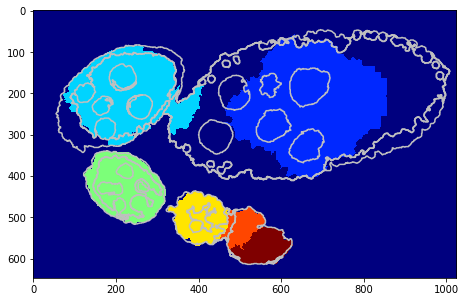

In [25]:
debug_gc_1m = {}
labels_gc = tl_rg.region_growing_shape_slic_graphcut(seg, slic, centers, (None, cdf), 'cdf', labels_fg_prob, 
                coef_shape=5., coef_pairwise=25., prob_label_trans=[0.1, 0.03], optim_global=True, allow_obj_swap=True, 
                dict_thresholds=tl_rg.DEFAULT_RG2SP_THRESHOLDS, nb_iter=65, dict_debug_history=debug_gc_1m)
segm_obj = labels_gc[slic]
print (debug_gd_mm.keys())
fig = plt.figure(figsize=FIG_SIZE)
plt.imshow(segm_obj, cmap=plt.cm.jet), plt.contour(seg, levels=np.unique(seg), colors='#bfbfbf')
# print debug_gc_1m.keys(), debug_gc_1m['centres']

Interastive visualisation - over iterations

<function __main__.show_partial>

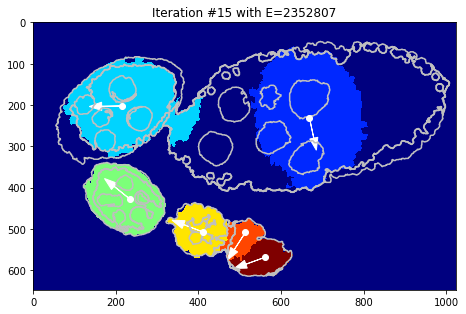

In [26]:
def show_partial(i):
    plt.close(), tl_visu.draw_rg2sp_results(plt.figure(figsize=FIG_SIZE).gca(), seg, slic, debug_gc_1m, i)
# show the interact
widgets.interact(show_partial, i=(0, len(debug_gc_1m['energy']) -1))

### Mixture model

['shifts', 'lut_data_cost', 'lut_shape_cost', 'centres', 'energy', 'labels']


(<matplotlib.image.AxesImage at 0x7f26025cc950>,
 <matplotlib.contour.QuadContourSet at 0x7f26027b1e50>)

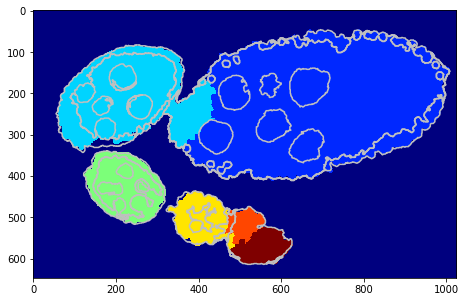

In [27]:
debug_gc_mm = {}
labels_gc = tl_rg.region_growing_shape_slic_graphcut(seg, slic, centers, (model, list_mean_cdf), 'set_cdfs', labels_fg_prob, 
                coef_shape=5., coef_pairwise=15., prob_label_trans=[0.1, 0.03], optim_global=False, allow_obj_swap=False, 
                dict_thresholds=tl_rg.DEFAULT_RG2SP_THRESHOLDS, nb_iter=65, dict_debug_history=debug_gc_mm)
segm_obj = labels_gc[slic]
print (debug_gd_mm.keys())
fig = plt.figure(figsize=FIG_SIZE)
plt.imshow(segm_obj, cmap=plt.cm.jet), plt.contour(seg, levels=np.unique(seg), colors='#bfbfbf')

Interastive visualisation - over iterations

<function __main__.show_partial>

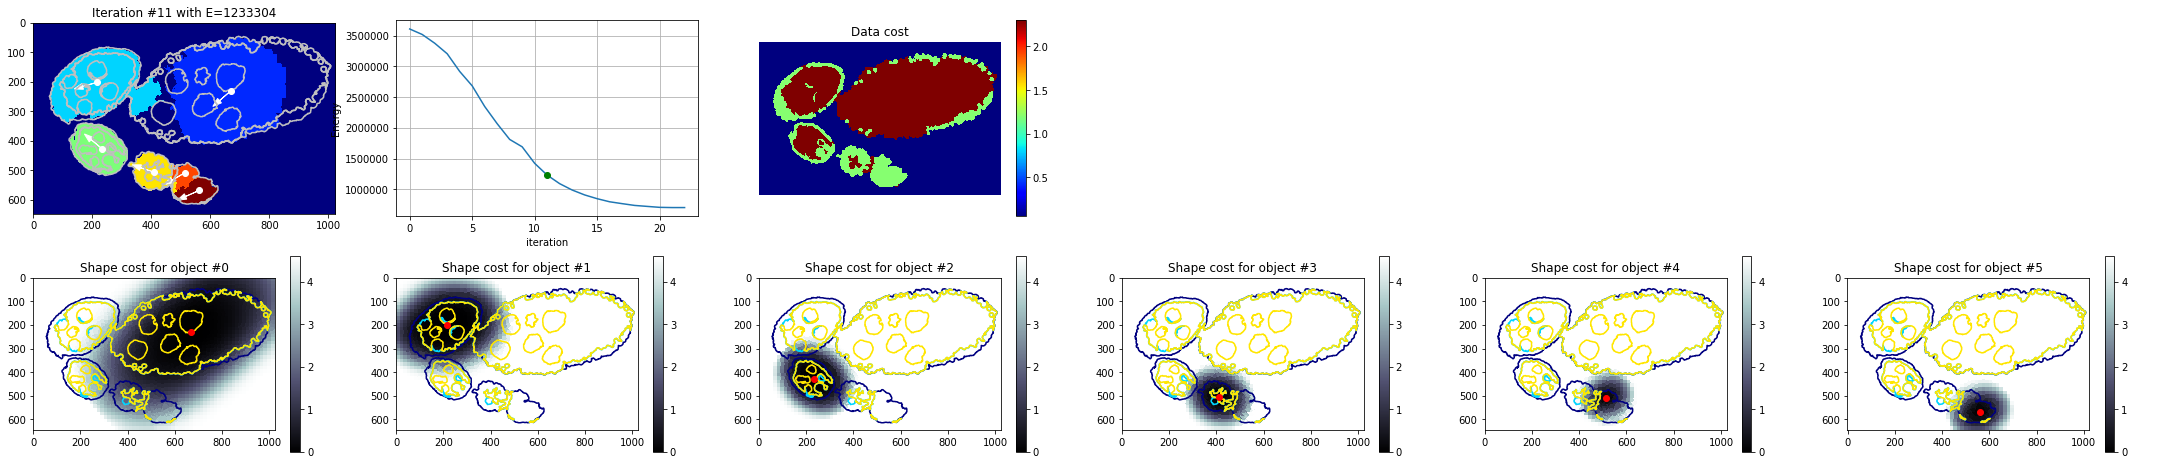

In [28]:
def show_partial(i):
    plt.close(), tl_visu.figure_rg2sp_debug_complete(seg, slic, debug_gc_mm, i, max_size=5)
# show the interact
widgets.interact(show_partial, i=(0, len(debug_gc_mm['energy']) -1))

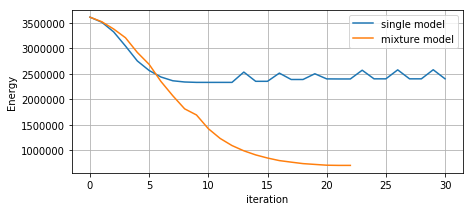

In [29]:
fig = plt.figure(figsize=(7, 3))
plt.plot(debug_gc_1m['energy'], label='single model')
plt.plot(debug_gc_mm['energy'], label='mixture model')
_= plt.ylabel('Energy'), plt.xlabel('iteration'), plt.grid(), plt.legend(loc='upper right')

### Visualise some iterations

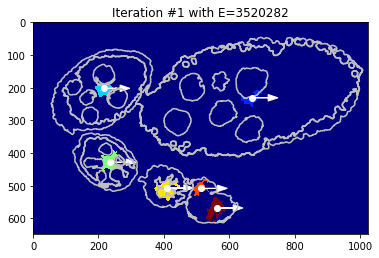

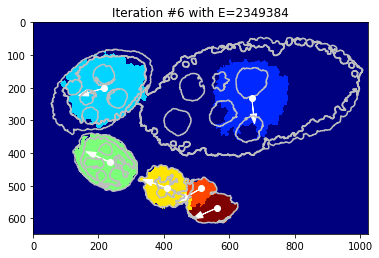

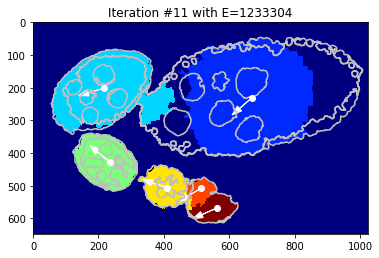

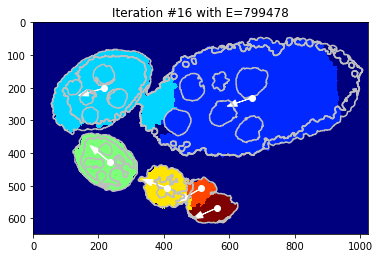

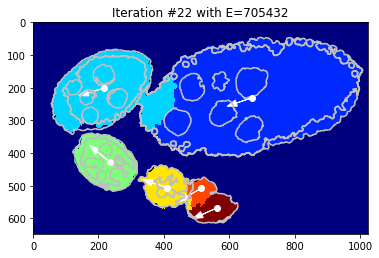

In [30]:
nb_iter = len(debug_gc_mm['energy'])
for i in np.linspace(1, nb_iter - 1, 5):
    _= tl_visu.draw_rg2sp_results(plt.figure().gca(), seg, slic, debug_gc_mm, int(i))

### Exporting iteretions

In [44]:
nb_iter = len(debug_gc_mm['energy'])
path_out = tl_io.find_path_bubble_up('output')
fig_size = np.array(FIG_SIZE) * np.array([debug_gc_mm['lut_data_cost'].shape[1] - 1, 2]) / 2.
for i in range(nb_iter):
    fig = plt.figure(figsize=fig_size)    
    tl_visu.draw_rg2sp_results(fig.gca(), seg, slic, debug_gc_mm, int(i))
    plt.savefig(os.path.join(path_out, 'debug-gc-mm_iter-%03d' % i))
    plt.close(fig)

## Compare GC and Greedy

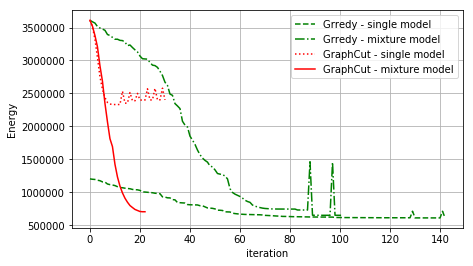

In [31]:
fig = plt.figure(figsize=(7, 4))
plt.plot(debug_gd_1m['energy'], 'g--', label='Grredy - single model')
plt.plot(debug_gd_mm['energy'], 'g-.', label='Grredy - mixture model')
plt.plot(debug_gc_1m['energy'], 'r:', label='GraphCut - single model')
plt.plot(debug_gc_mm['energy'], 'r-', label='GraphCut - mixture model')
_= plt.ylabel('Energy'), plt.xlabel('iteration'), plt.grid(), plt.legend(loc='upper right')
# fig.subplots_adjust(left=0.15, bottom=0.12, right=0.99, top=0.9)
# fig.savefig(os.path.join(PATH_OUT, 'figure_RG-energy-iter.pdf'))